In [1]:
import os
import torch
import json

basepath = "/home/xchen/SMOO/"
data_path = os.path.join(basepath, 'data')
print(data_path, os.path.isdir(data_path))

/home/xchen/SMOO/data True


In [2]:
target_classes = {205: 'flat-coated retriever',
                  206: 'curly-coated retriever',
                  207: 'golden retriever',
                  208: 'Labrador retriever',
                  209: 'Chesapeake Bay retriever'}#  {205, 206,207,208,209}
num_samples=200
layer_names = ['input.affine', 'L0_36_1024.affine', 'L1_36_1024.affine', 'L2_36_1024.affine', 'L3_36_1024.affine', 'L4_36_1024.affine', 'L5_36_1024.affine', 'L6_36_1024.affine', 'L7_36_1024.affine', 'L9_36_1024.affine', 'L10_52_1024.affine', 'L11_52_1024.affine', 'L12_52_1024.affine', 'L13_52_1024.affine', 'L14_52_1024.affine', 'L15_84_1024.affine', 'L16_84_1024.affine', 'L17_84_1024.affine', 'L18_84_1024.affine', 'L19_84_1024.affine', 'L20_148_1024.affine', 'L21_148_861.affine', 'L22_148_724.affine', 'L23_148_609.affine', 'L24_148_512.affine', 'L25_128_512.affine', 'L26_128_3.affine']
contents = ['values', 'grad']

def load_data(target_class_id, id):
    _path = os.path.join(data_path, str(target_class_id), str(id))
    assert os.path.isdir(_path), f"Path {_path} does not exist"
    # load .pt file
    gradient = torch.load(os.path.join(_path, f'gradient_{id}.pt'), weights_only=True)
    print(gradient.keys())
    print(gradient['input.affine']['grad'])

def load_and_normalize_data(data_path, target_class_ids, num_samples, layer_names,
                            content = 'values',norm_type='min-max',
                            normalization = True):
    """
    Load all gradient values across the population and normalize them.

    Args:
        data_path (str): Path to the data directory.
        target_class_ids (list): List of target class IDs (e.g., [205, 206...]).
        num_samples (int): Number of samples per class.
        layer_names (list): List of layer names to process.
        norm_type (str): Type of normalization ('min-max' or 'z-score').

    Returns:
        dict: A normalized dictionary of population data, structured similarly to the input.
    """
    # Store all values from the population
    population_values = {layer: [] for layer in layer_names}
    predictions = {'labels': [] , 'predictions': [], 'misclassifications': []}
    # Load data from all target classes and samples
    for target_class_id in target_class_ids:
        for sample_id in range(num_samples):
            # Construct the path to the gradient file
            gradient_path = os.path.join(data_path, str(target_class_id), str(sample_id), f'gradient_{sample_id}.pt')

            # Load the .pt file
            if not os.path.isfile(gradient_path):
                print(f"Warning: {gradient_path} not found, skipping.")
                continue
            gradient = torch.load(gradient_path, weights_only=True)

            # load predictions
            metadata_path = os.path.join(data_path, str(target_class_id), str(sample_id), f'metadata_{sample_id}.json')
            if not os.path.isfile(metadata_path):
                print(f"Warning: {metadata_path} not found, skipping.")
                continue
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)

            # Collect values for each layer
            for layer in layer_names:
                if layer in gradient and content in gradient[layer]:
                    population_values[layer].append(gradient[layer][content])

            predictions['labels'].append(target_class_id)
            predictions['predictions'].append(metadata['predicted_class'])
            predictions['misclassifications'].append(target_class_id != metadata['predicted_class'])

    # Normalize the population values for each layer
    normalized_population = {}
    for layer, tensors in population_values.items():
        if len(tensors) == 0:
            print(f"No data found for layer: {layer}, skipping normalization.")
            continue

        # Stack all values into a single tensor
        stack = torch.stack(tensors)
        if normalization:
            if norm_type == 'min-max':
                # Min-max normalization to [0, 1]
                min_val = stack.min()
                max_val = stack.max()
                normalized_population[layer] = [(t - min_val) / (max_val - min_val) for t in tensors]
            elif norm_type == 'z-score':
                # Z-score normalization
                mean = stack.mean()
                std = stack.std()
                normalized_population[layer] = [(t - mean) / std for t in tensors]
            else:
                raise ValueError(f"Unsupported norm_type: {norm_type}. Use 'min-max' or 'z-score'.")
        else:
            normalized_population[layer] = tensors
    return normalized_population, predictions




In [7]:
target_class_ids = [205, 206, 207, 208, 209]
num_samples = 200
layer_names = [
    'input.affine', 'L0_36_1024.affine', 'L1_36_1024.affine',
    'L2_36_1024.affine', 'L3_36_1024.affine', 'L4_36_1024.affine'
    # Add the complete list of layers here...
]
normalized_data, predictions = load_and_normalize_data(
    data_path=data_path,
    target_class_ids=target_class_ids,
    num_samples=num_samples,
    layer_names=layer_names,
    norm_type='z-score',  # Change to 'z-score' if needed
    normalization = False,
    content = 'grad'
)

In [8]:
normalized_data

{'input.affine': [tensor([[ 0.9564, -6.5640, -3.5620, -3.1368]], device='cuda:0'),
  tensor([[-34.6835,  44.2470,  20.4313, -40.1652]], device='cuda:0'),
  tensor([[  0.2227,  25.9725,  31.3554, -12.4406]], device='cuda:0'),
  tensor([[ 0.6040, 24.5001, 20.5973, -3.8089]], device='cuda:0'),
  tensor([[-5.7535, -0.8150,  4.0130, -8.8492]], device='cuda:0'),
  tensor([[-2.4014, 10.5268, 17.0753,  0.4081]], device='cuda:0'),
  tensor([[ 36.0236, -34.0422, -19.0768,  36.4445]], device='cuda:0'),
  tensor([[-23.1848,   9.1146,  -2.7866, -31.5513]], device='cuda:0'),
  tensor([[-10.6423,  -1.6361, -11.0192,  -6.3330]], device='cuda:0'),
  tensor([[-0.7035, -9.2114, -5.2579,  1.9975]], device='cuda:0'),
  tensor([[ -8.6055, -12.8197, -13.5281,  -6.6659]], device='cuda:0'),
  tensor([[  6.4333,  -1.2702, -10.8661,   8.1247]], device='cuda:0'),
  tensor([[17.2091,  8.8098, 13.1117, 24.7850]], device='cuda:0'),
  tensor([[ -2.8387,  -7.4704, -12.3330,   4.9284]], device='cuda:0'),
  tensor([[-54

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def flatten_and_aggregate(normalized_data, layer_names, samples_per_class=200):
    """
    Flatten and aggregate normalized data to create feature vectors for each sample.

    Args:
        normalized_data (list of dict): List of normalized gradient dictionaries for each sample.
                                        Each dictionary contains layer names as keys and flattened tensors as values.
        layer_names (list): List of layer names to consider for flattening and aggregation.

    Returns:
        np.ndarray: Feature matrix where rows are samples and columns are concatenated features.
    """
    # List to store the aggregated feature vectors for all samples
    aggregated_features = []
    num_samples = len(normalized_data[list(normalized_data.keys())[0]])
    # Iterate over all samples in the normalized data
    for sample_id in range(num_samples):
        sample_vector = []
        for layer_name in layer_names:
            sample_vector.extend(normalized_data[layer_name][sample_id].squeeze().tolist())

        # Append the flattened and aggregated sample vector
        aggregated_features.append(sample_vector)

    # Convert all sample vectors into a 2D NumPy array (samples x features)
    feature_matrix = np.array(aggregated_features)
    print(f"Feature matrix shape: {feature_matrix.shape} (samples, features)")
    return feature_matrix

feature_matrix = flatten_and_aggregate(normalized_data, layer_names)
def clean_data(data_matrix):
    """Cleans the data by replacing NaNs/Infs with column means."""
    if not np.isfinite(data_matrix).all():
        print("Data contains NaNs or Infs. Cleaning the data...")
        # Replace NaN and Inf values with the mean of their respective columns
        col_means = np.nanmean(np.where(np.isfinite(data_matrix), data_matrix, np.nan), axis=0)
        data_matrix = np.where(np.isfinite(data_matrix), data_matrix, col_means[np.newaxis, :])
    return data_matrix

feature_matrix = clean_data(feature_matrix)




Feature matrix shape: (1000, 5124) (samples, features)


In [10]:
feature_matrix

array([[ 9.56383467e-01, -6.56396627e+00, -3.56195569e+00, ...,
        -2.96686329e-02, -1.91208217e-02,  1.39065892e-01],
       [-3.46834717e+01,  4.42470207e+01,  2.04313030e+01, ...,
         1.07373372e-02,  6.60337135e-02,  7.52812847e-02],
       [ 2.22718239e-01,  2.59724693e+01,  3.13553524e+01, ...,
         5.18187881e-03,  1.96957681e-02,  6.41528219e-02],
       ...,
       [ 4.89235306e+00, -3.62457418e+00, -3.94634247e+00, ...,
        -1.11051276e-01, -3.39546148e-03, -5.74289337e-02],
       [-1.29804726e+01,  3.52714443e+00,  2.76299977e+00, ...,
        -3.13241221e-02, -7.59656057e-02,  8.36758837e-02],
       [-1.09956341e+01, -3.48293638e+00, -5.09209824e+00, ...,
         4.11077514e-02, -1.56541970e-02, -3.66829336e-02]])

In [11]:

def perform_pca_analysis(data_matrix, n_components=0.95):
    """
    Perform PCA on a data matrix.

    Args:
        data_matrix (np.ndarray): Input data (samples x features).
        n_components (float or int): Number of components, or the amount of variance to preserve.

    Returns:
        PCA: Fitted PCA object.
        np.ndarray: Transformed data (samples x n_components).
    """
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(data_matrix)

    # Results
    print(f"Original data shape: {data_matrix.shape}")
    print(f"Transformed data shape: {pca_transformed.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")
    return pca, pca_transformed

pca, pca_transformed = perform_pca_analysis(feature_matrix, n_components=2)


Original data shape: (1000, 5124)
Transformed data shape: (1000, 2)
Explained variance ratio: [0.70407298 0.03077642]
Cumulative explained variance: [0.70407298 0.7348494 ]


In [12]:
pca_transformed

array([[-2.34226870e+01, -1.12667719e+02],
       [-8.14953974e+02,  3.77509327e+01],
       [-2.15887542e+02, -1.30282140e+02],
       ...,
       [-5.62810244e-10, -8.28330131e-11],
       [ 7.28373976e-10, -3.61500282e-12],
       [-5.74358552e-10, -1.71488294e-10]])

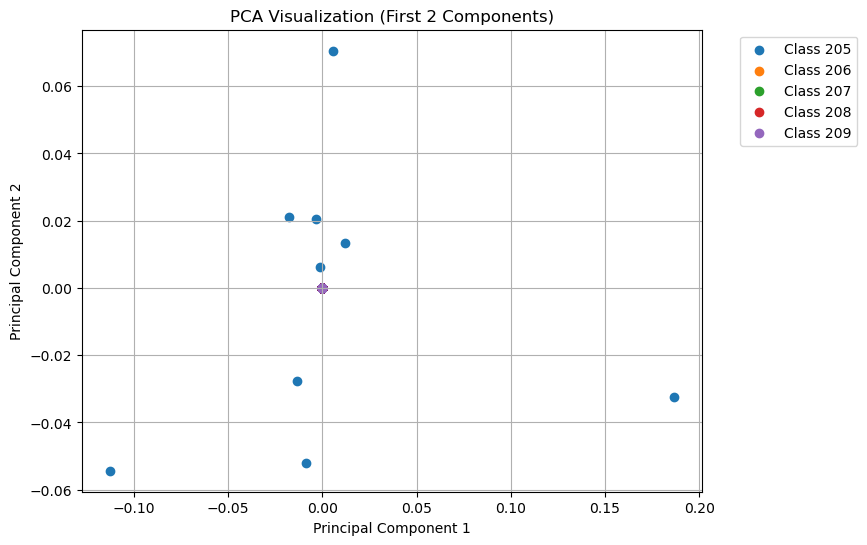

In [17]:
def plot_pca_results(pca_transformed, target_class_ids, labels):
    """
    Plot the PCA-transformed data.

    Args:
        pca_transformed (np.ndarray): Transformed data from PCA (samples x components).
        target_class_ids (list): List of class IDs for coloring points.
        labels (list): Optional labels for each sample.
    """
    # Only plot the first two components
    plt.figure(figsize=(8, 6))
    for class_id in target_class_ids:
        class_indices = [i for i, label in enumerate(labels) if label == class_id]
        plt.scatter(pca_transformed[class_indices, 0], pca_transformed[class_indices, 1], label=f"Class {class_id}")

    plt.title("PCA Visualization (First 2 Components)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.show()

plot_pca_results(pca_transformed[3:,], target_class_ids, labels=predictions['labels'][3:])

In [29]:
feature_matrix.shape

(1000, 5124)

In [15]:
predictions['labels']

[205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205,
 205